In [ ]:
# Imports
# Numerical/scientific computing packages
import numpy as np
import scipy
import pandas as pd
# Machine learning package.
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# Plotting packages.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
# one hot-encode the zodiac
# don't want to need a legend
# if off by a certain RMSE - this depends on the feature scale

# Data Cleanup

In [ ]:
# Load data into pandas
raw_df = pd.read_csv('techSalaries2017.csv')
raw_df.head()

,company,title,location,totalyearlycompensation,basesalary,stockgrantvalue,bonus,yearsofexperience,yearsatcompany,gender,...,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,Age,Height,Zodiac,SAT,GPA
0,Oracle,Product Manager,"Redwood City, CA",127000,107000,20000.0,10000.0,1.5,1.5,NaN,...,0,0,0,NaN,NaN,38,68.590,5,829,2.13
1,eBay,Software Engineer,"San Francisco, CA",100000,0,0.0,0.0,5.0,3.0,NaN,...,0,0,0,NaN,NaN,34,68.059,7,993,2.77
2,Amazon,Product Manager,"Seattle, WA",310000,155000,0.0,0.0,8.0,0.0,NaN,...,0,0,0,NaN,NaN,42,61.343,3,1200,3.26
3,Apple,Software Engineering Manager,"Sunnyvale, CA",372000,157000,180000.0,35000.0,7.0,5.0,NaN,...,0,0,0,NaN,NaN,28,66.495,3,1170,3.07
4,Microsoft,Software Engineer,"Mountain View, CA",157000,0,0.0,0.0,5.0,3.0,NaN,...,0,0,0,NaN,NaN,34,69.015,2,1115,2.91


In [ ]:
print(f"Shape: {raw_df.shape}")
print(f"Columns: {raw_df.columns}")
# Looking at NaN
nan_counts = raw_df.isna().sum()
print(nan_counts)

Shape: (62642, 27)
Columns: Index(['company', 'title', 'location', 'totalyearlycompensation', 'basesalary',
       'stockgrantvalue', 'bonus', 'yearsofexperience', 'yearsatcompany',
       'gender', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree',
       'Highschool', 'Some_College', 'Race_Asian', 'Race_White',
       'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic', 'Race', 'Education',
       'Age', 'Height', 'Zodiac', 'SAT', 'GPA'],
      dtype='object')
company                        5
title                          0
location                       0
totalyearlycompensation        0
basesalary                     0
stockgrantvalue                0
bonus                          0
yearsofexperience              0
yearsatcompany                 0
gender                     19540
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0


In [ ]:
### Dealing with race and education NaN

In [ ]:
df = raw_df.copy() # keeping raw df just in case - I will make all future processing occur on 'df'

# Race is self-identified in race_asian, white, race_two_or_more, race_black, race_hispanic
cur_race_col = [col for col in df if col.startswith('Race_')] # Gets all self-identified race columns
race_dict = {col: i+1 for i, col in enumerate(cur_race_col)} # Create a race mapping dictionary
df['race'] = df[cur_race_col].apply(lambda row: race_dict[row.idxmax()] if row.max() > 0 else np.nan, axis=1) # applying this mapping to "race" column

print(df['race'].isna().sum()) # Realized this is the same number as defined in the initial race 'qualitative column'
matching_nans = df['race'].isna() == df['Race'].isna()
print(matching_nans.all())  # Returns True if all NaN positions match

40215
True


In [ ]:
print(df['race'].value_counts())
print(df['Race'].value_counts())

race
1.0    11772
2.0     8032
5.0     1129
3.0      804
4.0      690
Name: count, dtype: int64
Race
Asian          11772
White           8032
Hispanic        1129
Two Or More      804
Black            690
Name: count, dtype: int64


In [ ]:
df.dropna(subset=['race'], inplace=True)
# Made me realize I might want to just go through education and do something similar - even if I am using the one-hot encodings
cur_edu_col = ['Masters_Degree','Bachelors_Degree', 'Doctorate_Degree', 'Highschool','Some_College']
edu_dict = {col: i+1 for i, col in enumerate(cur_edu_col)} # Create an edu dictionary
df['education'] = df[cur_edu_col].apply(lambda row: edu_dict[row.idxmax()] if row.max() > 0 else np.nan, axis=1) # applying this mapping to "education" column

In [ ]:
print(df['education'].isna().sum()) # Realized this is the same number as defined in the initial education 'qualitative column'
matching_nans = df['education'].isna() == df['Education'].isna()
print(matching_nans.all())  # Returns True if all NaN positions match

746
True


In [ ]:
print(df['education'].value_counts())
print(df['Education'].value_counts())

education
2.0    10968
1.0     9144
3.0      928
5.0      339
4.0      302
Name: count, dtype: int64
Education
Bachelor's Degree    10968
Master's Degree       9144
PhD                    928
Some College           339
Highschool             302
Name: count, dtype: int64


In [ ]:
df.dropna(subset=['education'], inplace=True)
df.drop(columns=['race', 'education'], inplace=True) # don't actually want to use these, want to keep the one-hot encodings
# also realized that our encodings are redundant with the 'qualitative columns'
df.drop(columns=['Race', 'Education'], inplace=True)
# not to mention that we can exclude one of these columns because the information from the rest will help us enough
df.drop(columns=['Highschool','Race_Two_Or_More'],inplace=True) # does not really matter which ones, so long as I keep it in mind for later

**Note: dropped highschool from education and two or more from races because of hot-encoding**

In [ ]:
# Check how we are doing with NaN
nan_counts = df.isna().sum()
print(nan_counts)

company                     2
title                       0
location                    0
totalyearlycompensation     0
basesalary                  0
stockgrantvalue             0
bonus                       0
yearsofexperience           0
yearsatcompany              0
gender                     90
Masters_Degree              0
Bachelors_Degree            0
Doctorate_Degree            0
Some_College                0
Race_Asian                  0
Race_White                  0
Race_Black                  0
Race_Hispanic               0
Age                         0
Height                      0
Zodiac                      0
SAT                         0
GPA                         0
dtype: int64


In [ ]:
### Dealing with gender and zodiac sign encoding

In [ ]:
df.dropna(subset=['gender'], inplace=True) # getting rid of gender NaN values since we have a good amount of data
df.shape

(21591, 23)

In [ ]:
# Gender
gender_enc = pd.get_dummies(df['gender'], prefix='Gender') # one-hot encoding gender
df = df.join(gender_enc)
df.drop(columns=['gender'], inplace=True)

# Male = 1 , Female = 0
df = df.loc[df["Gender_Other"] == False]
df.drop(columns=['Gender_Female', 'Gender_Other'], inplace=True) # will just use Gender_Male to avoid redundancy

In [ ]:
# Zodiac
zodiac_dict = {
    1: "Aries",
    2: "Taurus",
    3: "Gemini",
    4: "Cancer",
    5: "Leo",
    6: "Virgo",
    7: "Libra",
    8: "Scorpio",
    9: "Sagittarius",
    10: "Capricorn",
    11: "Aquarius",
    12: "Pisces"
}
df["Zodiac_Sign"] = df["Zodiac"].map(zodiac_dict)

# Encoding
zodiac_enc = pd.get_dummies(df['Zodiac_Sign'], prefix='Zodiac')
df = df.join(zodiac_enc)
df.drop(columns=['Zodiac','Zodiac_Sign'],inplace=True)
df.head()

,company,title,location,totalyearlycompensation,basesalary,stockgrantvalue,bonus,yearsofexperience,yearsatcompany,Masters_Degree,...,Zodiac_Cancer,Zodiac_Capricorn,Zodiac_Gemini,Zodiac_Leo,Zodiac_Libra,Zodiac_Pisces,Zodiac_Sagittarius,Zodiac_Scorpio,Zodiac_Taurus,Zodiac_Virgo
15710,Google,Software Engineer,"Sunnyvale, CA",400000,210000,145000.0,45000.0,5.0,5.0,0,...,False,False,False,False,False,False,True,False,False,False
23532,Microsoft,Software Engineer,"Redmond, WA",136000,124000,1000.0,11000.0,3.0,2.0,0,...,False,False,False,False,False,True,False,False,False,False
23533,Google,Software Engineer,"San Bruno, CA",337000,177000,125000.0,36000.0,6.0,6.0,0,...,False,False,False,False,False,False,False,False,False,False
23534,Microsoft,Software Engineer,"Seattle, WA",222000,164000,38000.0,20000.0,4.0,4.0,1,...,False,False,False,False,False,False,False,True,False,False
23535,Blend,Software Engineer,"San Francisco, CA",187000,165000,22000.0,0.0,5.0,0.0,0,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Again dropping a column because information is redundant
df.drop(columns=['Zodiac_Aries'], inplace=True)

In [ ]:
df.columns

Index(['company', 'title', 'location', 'totalyearlycompensation', 'basesalary',
       'stockgrantvalue', 'bonus', 'yearsofexperience', 'yearsatcompany',
       'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree',
       'Some_College', 'Race_Asian', 'Race_White', 'Race_Black',
       'Race_Hispanic', 'Age', 'Height', 'SAT', 'GPA', 'Gender_Male',
       'Zodiac_Aquarius', 'Zodiac_Cancer', 'Zodiac_Capricorn', 'Zodiac_Gemini',
       'Zodiac_Leo', 'Zodiac_Libra', 'Zodiac_Pisces', 'Zodiac_Sagittarius',
       'Zodiac_Scorpio', 'Zodiac_Taurus', 'Zodiac_Virgo'],
      dtype='object')

In [ ]:
df = df.astype({col: int for col in df.select_dtypes(include=['bool']).columns}) # make boolean values integers (0 or 1, 1 = True)
df.dtypes

,0
company,object
title,object
location,object
totalyearlycompensation,int64
basesalary,int64
stockgrantvalue,float64
bonus,float64
yearsofexperience,float64
yearsatcompany,float64
Masters_Degree,int64


# Quick Look at Data

In [ ]:
vis_df = raw_df.copy() # we want to look at the data itself not necessarily with any changes - this will help us analyze the data/make determinations
vis_df.head()
vis_df = vis_df.dropna()

In [ ]:
# Looking at first variable - Company
print(vis_df['company'].value_counts())
print(f"Companies Mentioned: {vis_df['company'].unique()}")
print(f"Total Companies Mentioned: {len(vis_df['company'].unique())}")

company
Amazon               2583
Microsoft            1619
Google               1314
Facebook             1001
Apple                 603
                     ... 
EverQuote               1
Collins aerospace       1
bank of america         1
Ama                     1
Amgen                   1
Name: count, Length: 1246, dtype: int64
Companies Mentioned: ['Google' 'Microsoft' 'Blend' ... 'Bankers Healthcare Group' 'Bukalapak'
 'Amgen']
Total Companies Mentioned: 1246


In [ ]:
# Get companies that appear more than 100 times
top_companies = df['company'].value_counts()
top_companies = top_companies[top_companies > 100].index  # Get company names
print(top_companies)

Index(['Amazon', 'Microsoft', 'Google', 'Facebook', 'Apple', 'Oracle', 'IBM',
       'Intel', 'Cisco', 'Salesforce', 'Capital One', 'VMware',
       'JPMorgan Chase', 'Deloitte', 'Uber', 'Goldman Sachs', 'Bloomberg',
       'LinkedIn', 'PayPal', 'Intuit', 'Accenture', 'Walmart Labs', 'Adobe',
       'Wayfair', 'Shopify', 'Qualcomm', 'SAP', 'Twitter', 'Expedia',
       'Nvidia'],
      dtype='object', name='company')


In [ ]:
# Over 1000 companies, so will group them according to the following
def categorize_company(company):
    tech_giants = top_companies.tolist()
    if company in tech_giants:
        return True
    else:
        return False

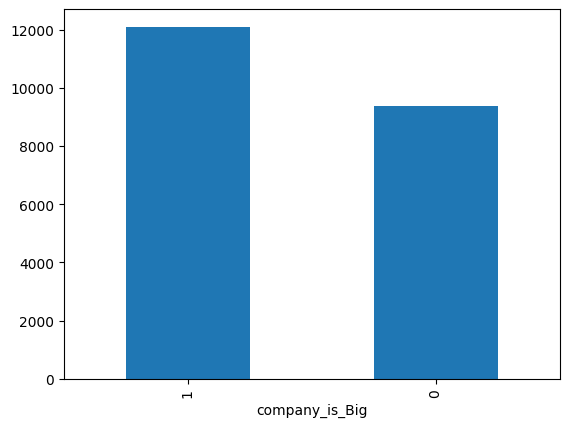

In [ ]:
df['company_is_Big'] = df['company'].apply(categorize_company).astype('int')
df['company_is_Big'].value_counts().plot(kind='bar')
df.drop(columns=['company'], inplace=True)

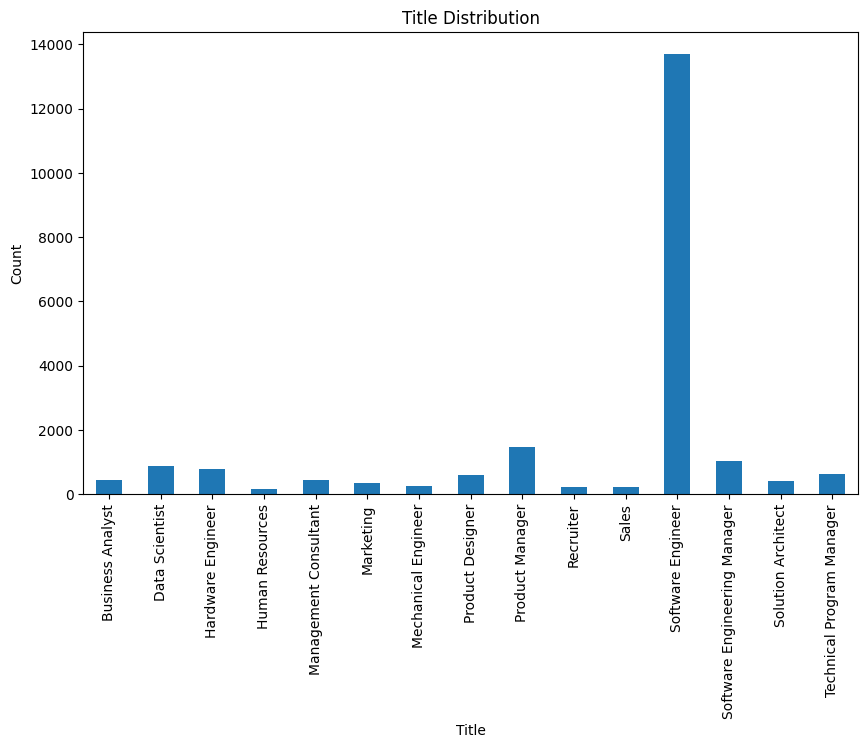

In [ ]:
# Second variable - Title
plt.figure(figsize=(10, 6))
vis_df['title'].value_counts().sort_index().plot(kind='bar')
plt.title('Title Distribution')
plt.xlabel('Title')
plt.ylabel('Count')
plt.show()

In [ ]:
# Based on this... we are mostly looking at software engineers so this is informative as to how to encode the title
# Let's just do software engineer vs. not a software engineer
df['is_SWE'] = (df['title'] == "Software Engineer").astype(int)
df.drop(columns=['title'], inplace=True) # drop previous title column

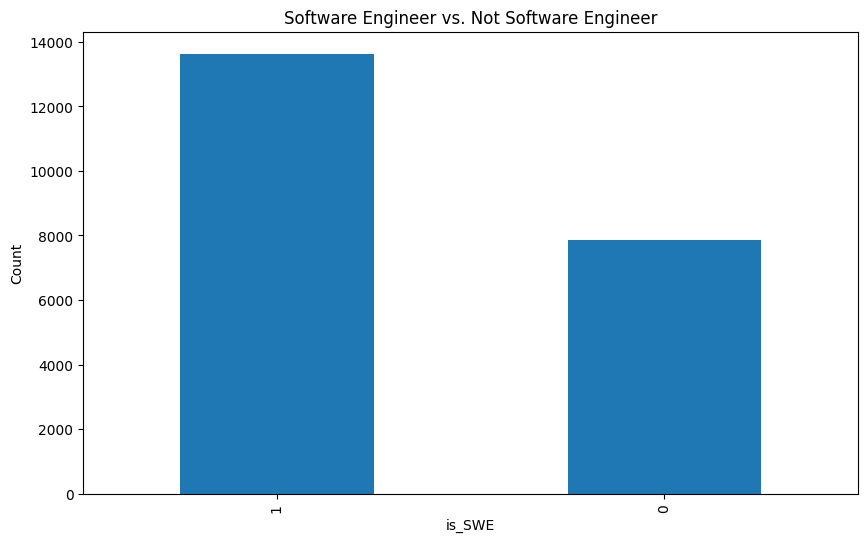

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Software Engineer vs. Not Software Engineer')
plt.xlabel('Software Engineer')
plt.ylabel('Count')
df['is_SWE'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
# Looking at location
print(vis_df['location'].value_counts())
print(f"Total Locations Mentioned: {len(vis_df['location'].unique())}")

location
Seattle, WA                    2516
San Francisco, CA              1759
New York, NY                   1605
Redmond, WA                     754
Mountain View, CA               647
                               ... 
Staines, EN, United Kingdom       1
Albany, NY                        1
Lansing, MI                       1
RIGA, RI, Latvia                  1
Pasir Ris, SG, Singapore          1
Name: count, Length: 768, dtype: int64
Total Locations Mentioned: 768


In [ ]:
# Did not realize we had different countries thrown in there!

# Let's look at this by country

us_states = {
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA',
    'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
    'VA', 'WA', 'WV', 'WI', 'WY'
}

# Determine the country
def get_country(location):
    parts = location.split(',')  # Split by comma

    if len(parts) == 2:  # city and state format
        state = parts[1].strip()
        if state in us_states:
            return "United States"

    elif len(parts) >= 3:  # has a country listed
        return parts[-1].strip()  # last part should be the country name

    return "Unknown"  # Fallback if the format is unexpected

# create a new 'country' column
vis_df['country'] = vis_df['location'].apply(get_country)

# Group by country and count occurrences
country_counts = vis_df['country'].value_counts()

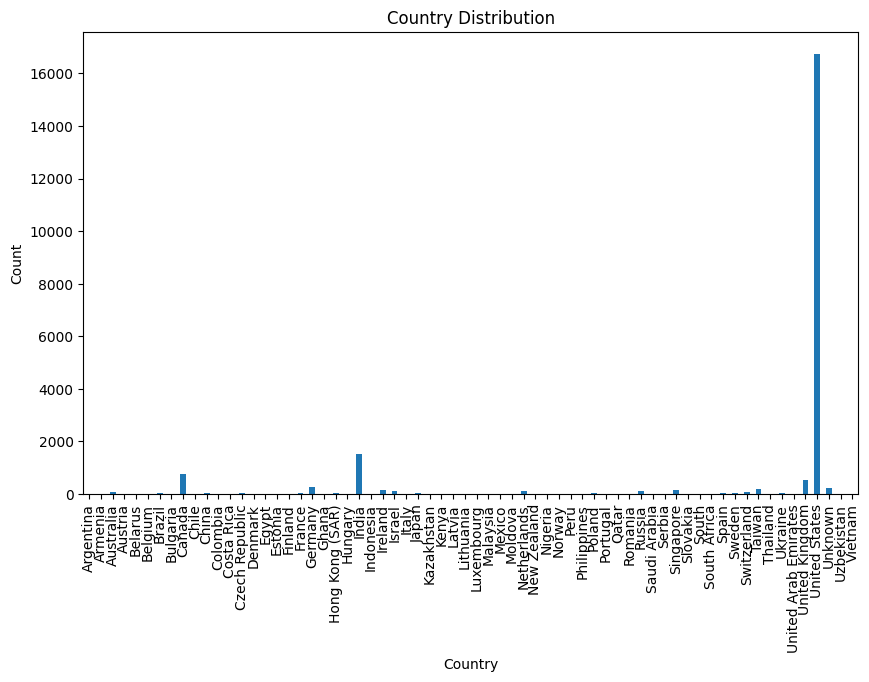

In [ ]:
# Country distribution
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
country_counts.sort_index().plot(kind='bar')
plt.title('Country Distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

In [ ]:
# US is definitely overrepresented, let's see what this looks like  - WOW 518 different cities
us_dist = vis_df[vis_df['country'] == 'United States']
us_dist['location'].value_counts()

,count
location,
"Seattle, WA",2516
"San Francisco, CA",1759
"New York, NY",1605
"Redmond, WA",754
"Mountain View, CA",647
...,...
"Franklin, TN",1
"Augusta, GA",1
"West Chester, OH",1


<ipython-input-31-e5982f385c0e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_dist['state'] = us_dist['location'].apply(get_state)


<Axes: title={'center': 'State Distribution'}, xlabel='state', ylabel='Count'>

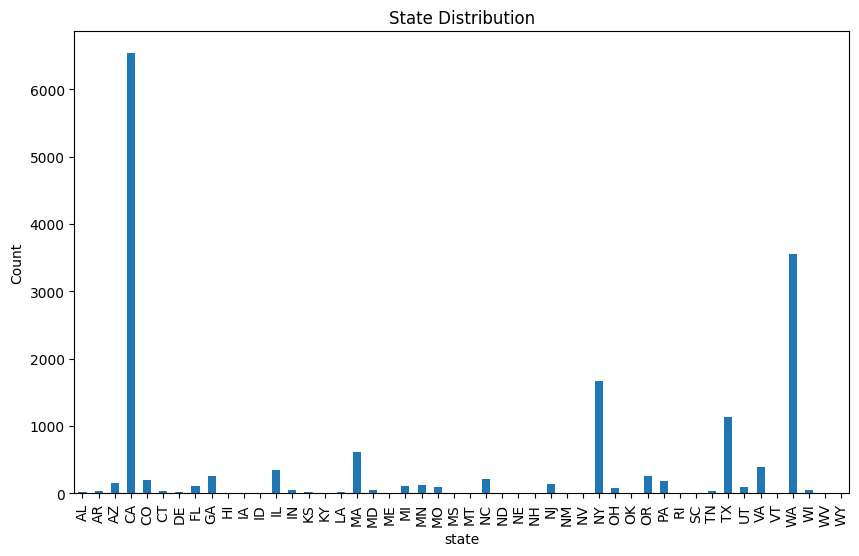

In [ ]:
def get_state(location):
    parts = location.split(',')  # Split by comma

    if len(parts) == 2:  # If it's a city and state format
        state = parts[1].strip()
        if state in us_states:
            return state

    return "Unknown"  # Fallback if the format is unexpected

# create a new 'state' column
us_dist['state'] = us_dist['location'].apply(get_state)
plt.figure(figsize=(10, 6))
plt.title('State Distribution')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
us_dist['state'].value_counts().sort_index().plot(kind='bar')

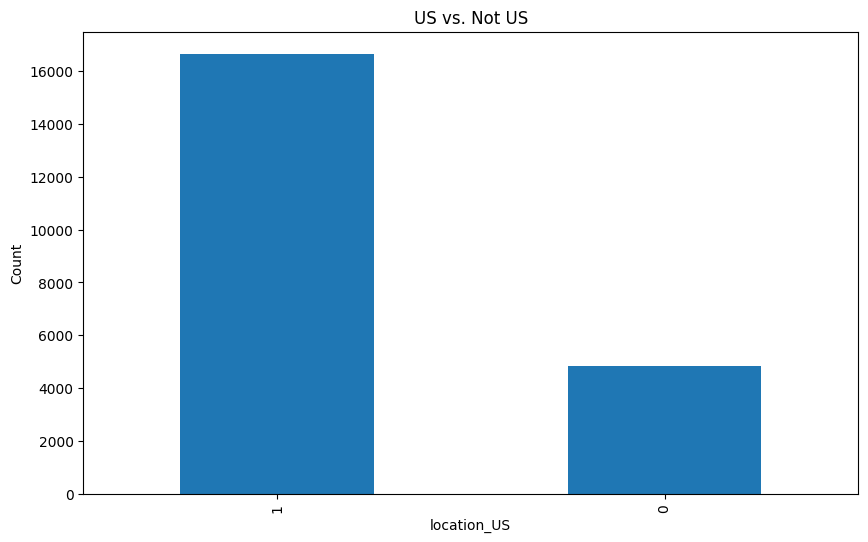

In [ ]:
# Based on this... we are mostly looking at people in the US, but if we want to use all of our data
# Makes the most sense to NOT breakdown by state but by country, even if we see a lot of different US cities represented as shown above
df['country'] = df['location'].apply(get_country)
df['location_US'] = (df['country'] == 'United States').astype(int)


plt.figure(figsize=(10, 6))
plt.title('US vs. Not US')
plt.xlabel('United States')
plt.ylabel('Count')
df['location_US'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
# Drop the temporary columns made
df.drop(columns=['location'], inplace=True)
df.drop(columns=['country'], inplace=True)

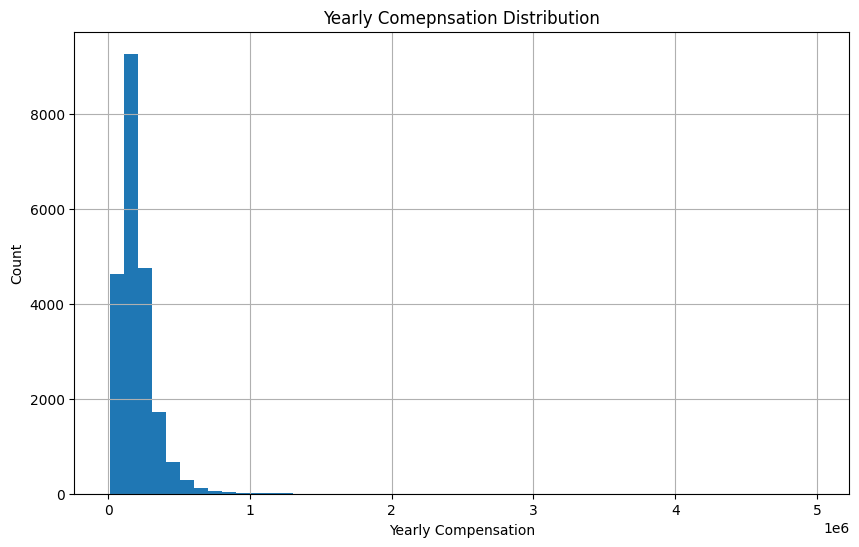

In [ ]:
# This is going to be what we predict
plt.figure(figsize=(10, 6))
vis_df['totalyearlycompensation'].hist(bins=50)
plt.title('Yearly Comepnsation Distribution')
plt.xlabel('Yearly Compensation')
plt.ylabel('Count')
plt.show()

In [ ]:
vis_df['totalyearlycompensation'].describe()

,totalyearlycompensation
count,2.158900e+04
mean,1.978564e+05
std,1.330941e+05
min,1.000000e+04
25%,1.190000e+05
50%,1.740000e+05
75%,2.450000e+05
max,4.980000e+06


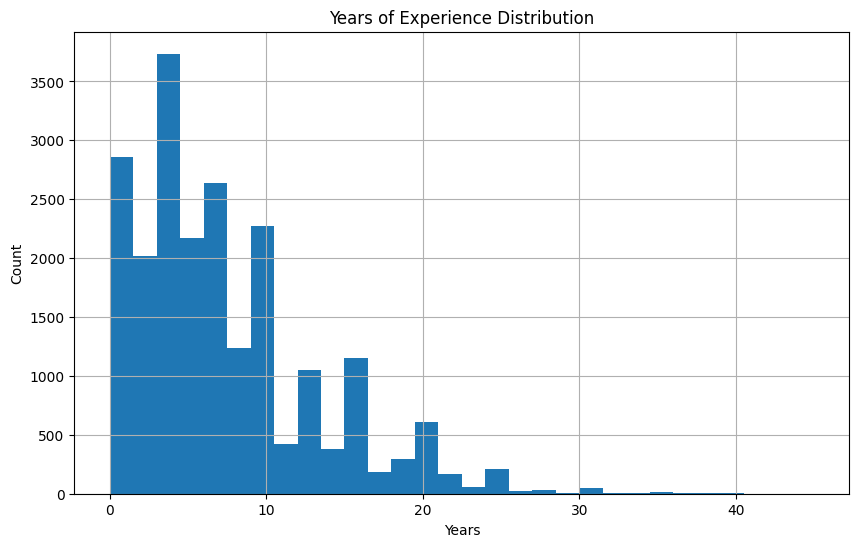

In [ ]:
# Years of experience
plt.figure(figsize=(10, 6))
vis_df['yearsofexperience'].hist(bins=30)
plt.title('Years of Experience Distribution')
plt.xlabel('Years')
plt.ylabel('Count')
plt.show()

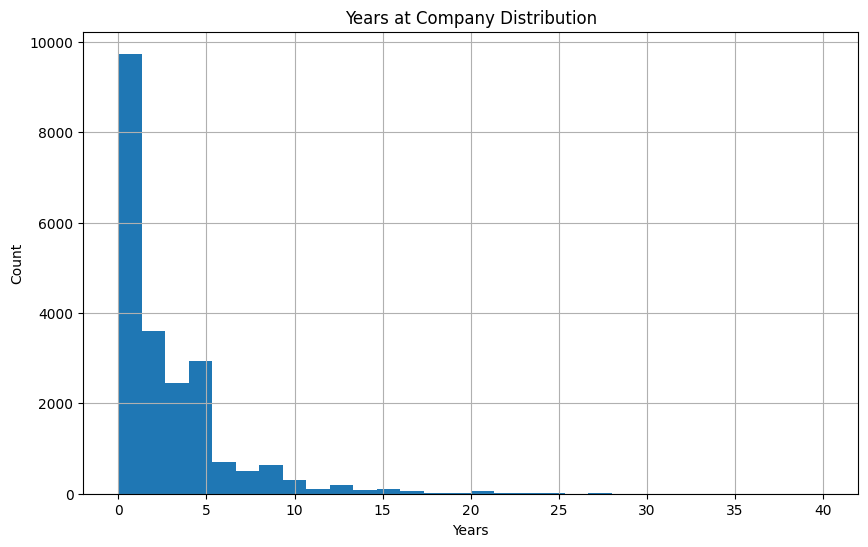

In [ ]:
# Years at company
plt.figure(figsize=(10, 6))
vis_df['yearsatcompany'].hist(bins=30)
plt.title('Years at Company Distribution')
plt.xlabel('Years')
plt.ylabel('Count')
plt.show()

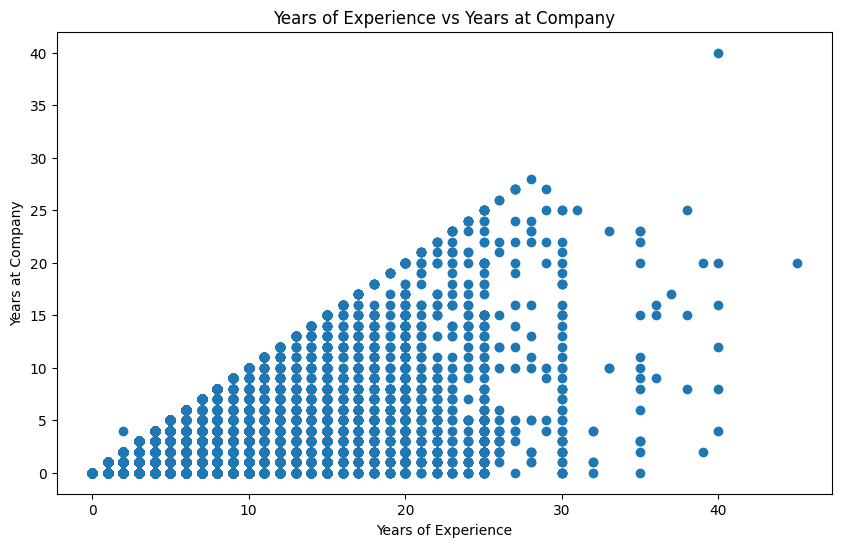

In [ ]:
# I wonder what the relationship between experience and time at a company looks like
plt.figure(figsize=(10, 6))
plt.scatter(vis_df['yearsofexperience'], vis_df['yearsatcompany'])
plt.title('Years of Experience vs Years at Company')
plt.xlabel('Years of Experience')
plt.ylabel('Years at Company')
plt.show()

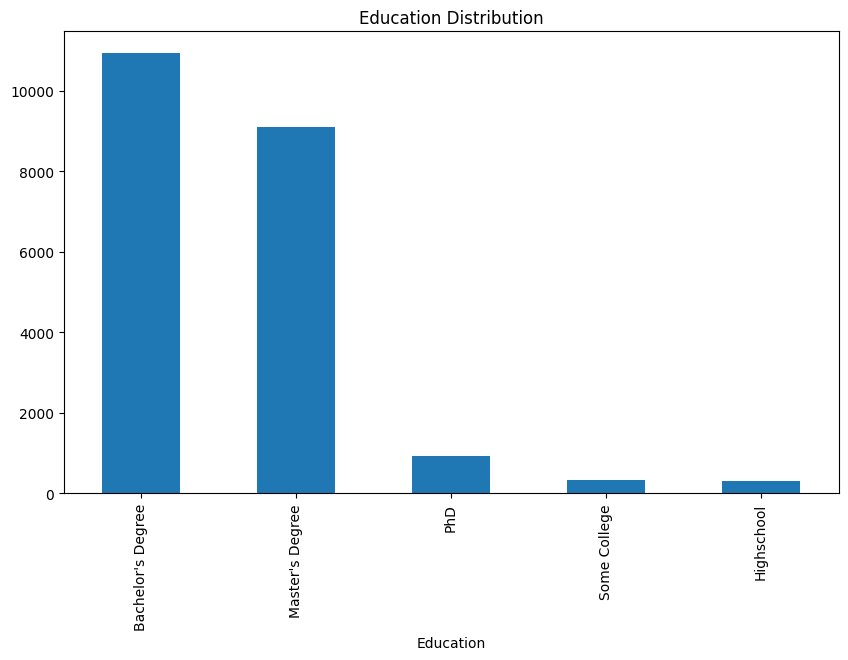

In [ ]:
plt.figure(figsize=(10, 6))
vis_df['Education'].value_counts().plot(kind='bar')
plt.title('Education Distribution')
plt.xlabel('Education')
plt.show()

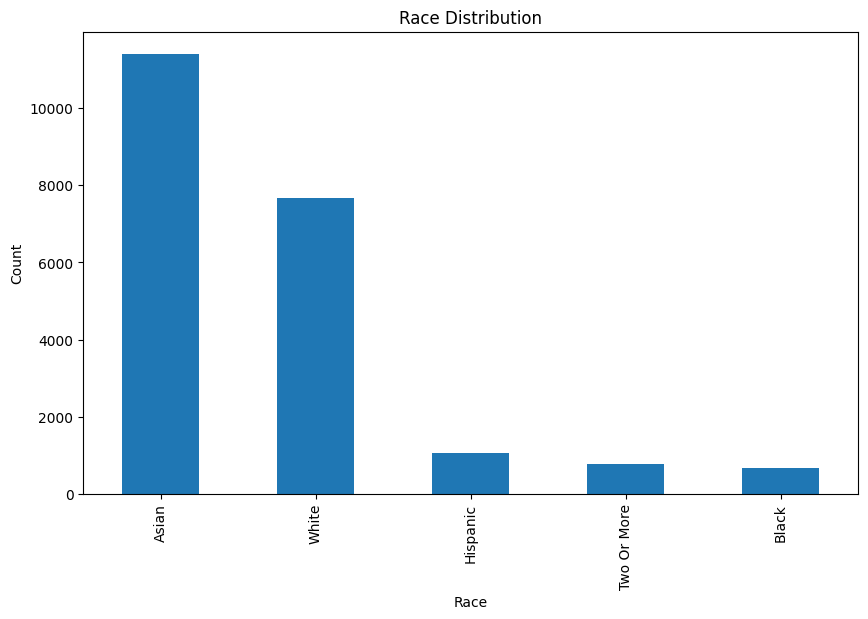

In [ ]:
plt.figure(figsize=(10, 6))
vis_df['Race'].value_counts().plot(kind='bar')
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

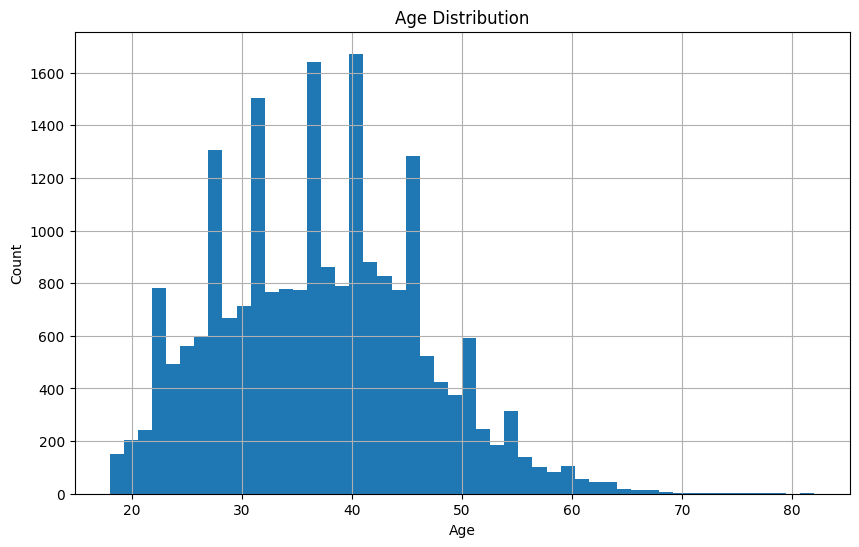

In [ ]:
plt.figure(figsize=(10, 6))
vis_df['Age'].hist(bins=50)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

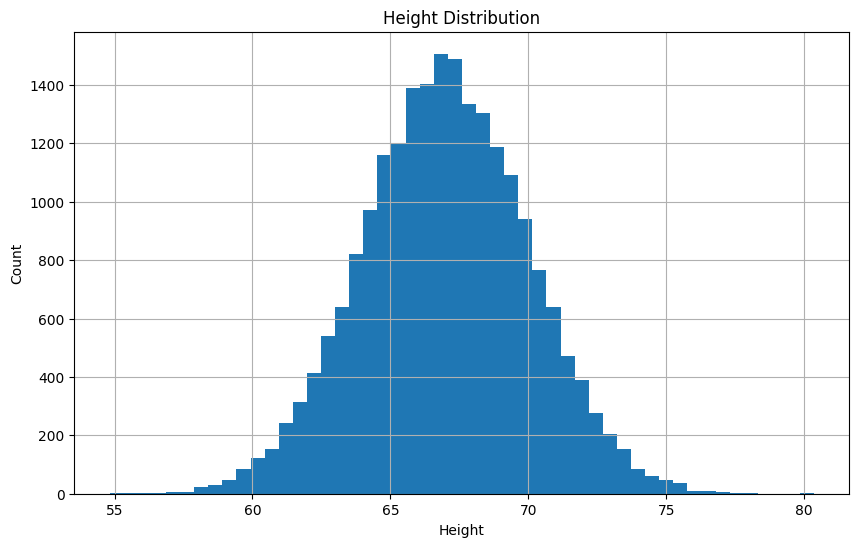

In [ ]:
plt.figure(figsize=(10, 6))
vis_df['Height'].hist(bins=50)
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.show()

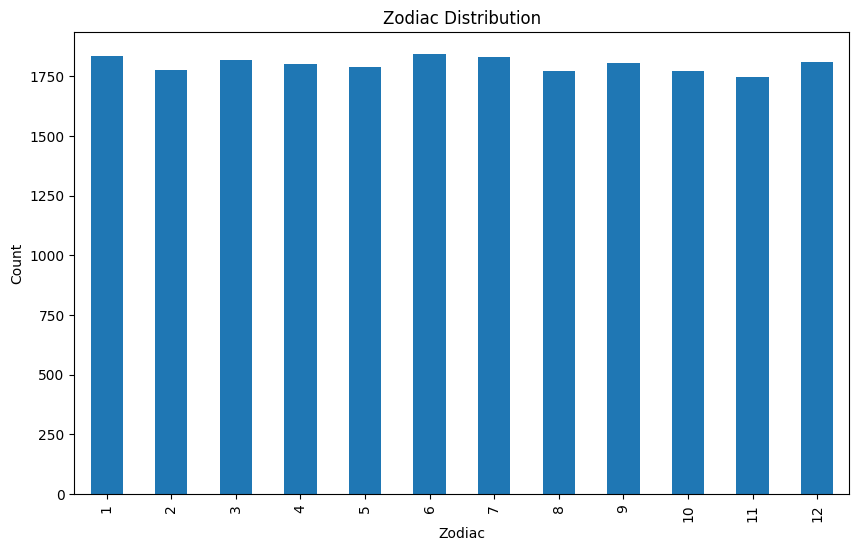

In [ ]:
plt.figure(figsize=(10, 6))
vis_df['Zodiac'].value_counts().sort_index().plot(kind='bar')
plt.title('Zodiac Distribution')
plt.xlabel('Zodiac')
plt.ylabel('Count')
plt.show()

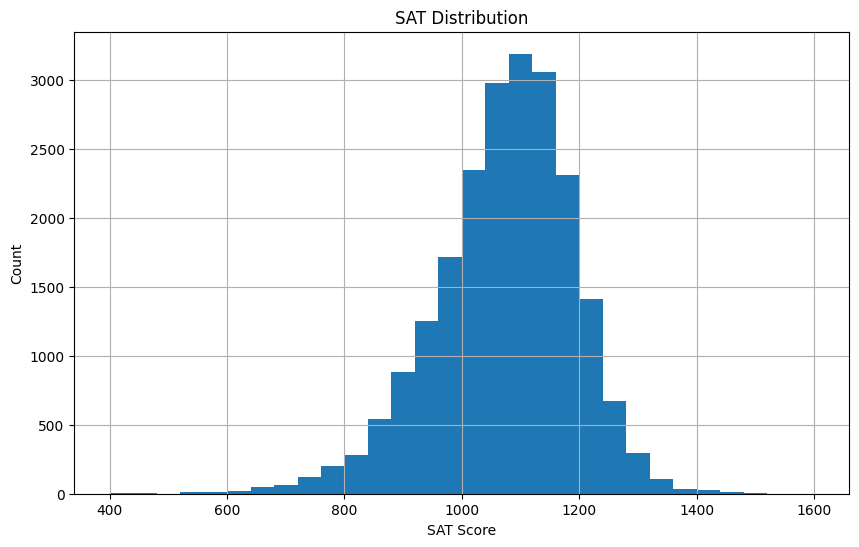

In [ ]:
plt.figure(figsize=(10, 6))
vis_df['SAT'].hist(bins=30)
plt.title('SAT Distribution')
plt.xlabel('SAT Score')
plt.ylabel('Count')
plt.show()

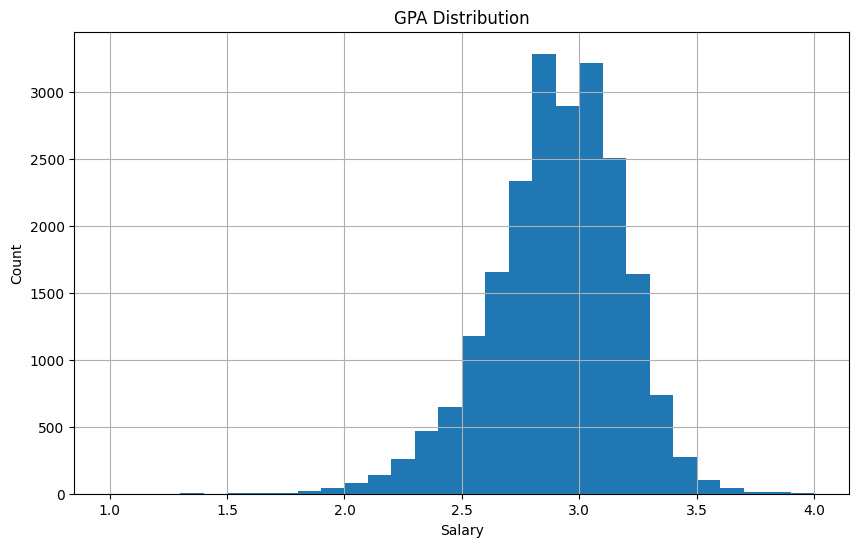

In [ ]:
plt.figure(figsize=(10, 6))
vis_df['GPA'].hist(bins=30)
plt.title('GPA Distribution')
plt.xlabel('Salary')
plt.ylabel('Count')
plt.show()

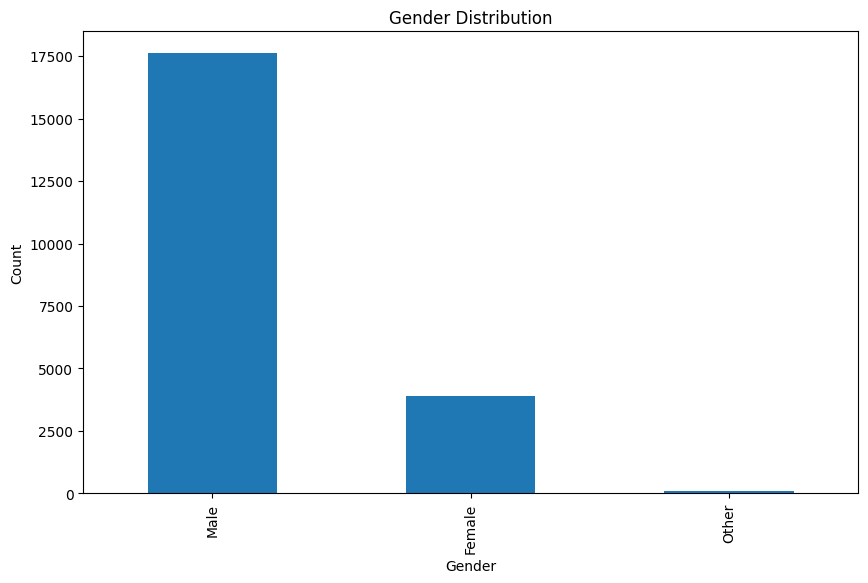

In [ ]:
plt.figure(figsize=(10, 6))
vis_df['gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Models

In [ ]:
# Know that I have to convert to numpy array so just want to make sure I have a way of staying clear with the variables
i = 0
idx_dict = {}
for col in df.columns:
  idx_dict[i] = col
  i=i+1

In [ ]:
for k,v in idx_dict.items():
  print(f"{k}: {v}")

0: totalyearlycompensation
1: basesalary
2: stockgrantvalue
3: bonus
4: yearsofexperience
5: yearsatcompany
6: Masters_Degree
7: Bachelors_Degree
8: Doctorate_Degree
9: Some_College
10: Race_Asian
11: Race_White
12: Race_Black
13: Race_Hispanic
14: Age
15: Height
16: SAT
17: GPA
18: Gender_Male
19: Zodiac_Aquarius
20: Zodiac_Cancer
21: Zodiac_Capricorn
22: Zodiac_Gemini
23: Zodiac_Leo
24: Zodiac_Libra
25: Zodiac_Pisces
26: Zodiac_Sagittarius
27: Zodiac_Scorpio
28: Zodiac_Taurus
29: Zodiac_Virgo
30: company_is_Big
31: is_SWE
32: location_US


In [ ]:
from sklearn.preprocessing import StandardScaler
continuous_features = ['yearsofexperience', 'yearsatcompany', 'Age', 'Height', 'SAT', 'GPA'] # some features still need standardization
scaler = StandardScaler() # works the way that was brought up in lab for normalization
std_df = df.copy() # just want to have the actual numbers in case !
std_df[continuous_features] = scaler.fit_transform(std_df[continuous_features]) # fit and transform only the selected features

In [ ]:
std_df.to_csv('std_df.csv')

In [ ]:
data = std_df.to_numpy()

In [ ]:
data.shape

(21485, 33)

In [ ]:
y = data[:,0] # total yearly compensation is predictor
X = np.delete(data, [0,1,2,3], axis=1) # exclude total yearly compensation from X as well as obvious features (given in HW 2 specs)

## Multiple Linear Regression

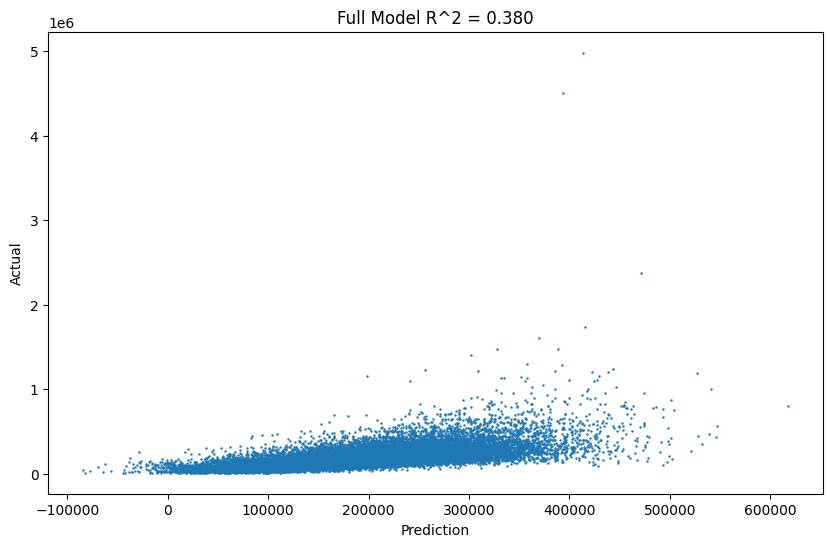

In [ ]:
# Full model
full_model = LinearRegression()
full_model.fit(X, y)
full_model_r2 = full_model.score(X, y)
yHat = full_model.predict(X)
plt.figure(figsize=(10, 6))
plt.plot(yHat,y,'o',markersize=.75)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Full Model R^2 = {:.3f}'.format(full_model_r2))
plt.savefig('full_model_mlr.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
X_df = std_df.drop(columns=['totalyearlycompensation', 'basesalary', 'stockgrantvalue','bonus'])
# Know that I have to convert to numpy array so just want to make sure I have a way of staying clear with the variables
i = 0
for col in X_df.columns:
  print(f"{i}:{col}")
  i=i+1

0:yearsofexperience
1:yearsatcompany
2:Masters_Degree
3:Bachelors_Degree
4:Doctorate_Degree
5:Some_College
6:Race_Asian
7:Race_White
8:Race_Black
9:Race_Hispanic
10:Age
11:Height
12:SAT
13:GPA
14:Gender_Male
15:Zodiac_Aquarius
16:Zodiac_Cancer
17:Zodiac_Capricorn
18:Zodiac_Gemini
19:Zodiac_Leo
20:Zodiac_Libra
21:Zodiac_Pisces
22:Zodiac_Sagittarius
23:Zodiac_Scorpio
24:Zodiac_Taurus
25:Zodiac_Virgo
26:company_is_Big
27:is_SWE
28:location_US


yearsofexperience R^2: 0.1609
yearsatcompany R^2: 0.0281
Masters_Degree R^2: 0.0097
Bachelors_Degree R^2: 0.0240
Doctorate_Degree R^2: 0.0198
Some_College R^2: 0.0002
Race_Asian R^2: 0.0013
Race_White R^2: 0.0023
Race_Black R^2: 0.0005
Race_Hispanic R^2: 0.0001
Age R^2: 0.0642
Height R^2: 0.0001
SAT R^2: 0.1106
GPA R^2: 0.0934
Gender_Male R^2: 0.0015
Zodiac_Aquarius R^2: 0.0001
Zodiac_Cancer R^2: 0.0000
Zodiac_Capricorn R^2: 0.0002
Zodiac_Gemini R^2: 0.0000
Zodiac_Leo R^2: 0.0000
Zodiac_Libra R^2: 0.0001
Zodiac_Pisces R^2: 0.0003
Zodiac_Sagittarius R^2: 0.0001
Zodiac_Scorpio R^2: 0.0001
Zodiac_Taurus R^2: 0.0000
Zodiac_Virgo R^2: 0.0000
company_is_Big R^2: 0.0345
is_SWE R^2: 0.0122
location_US R^2: 0.1289


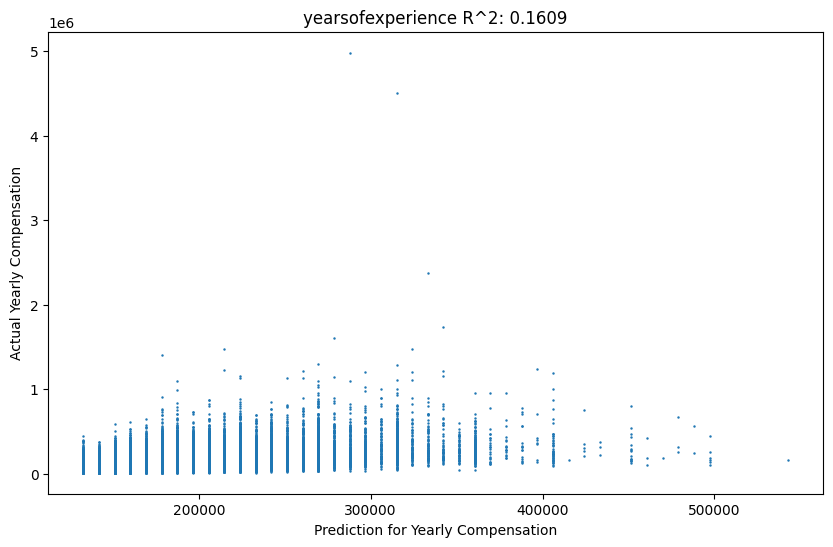

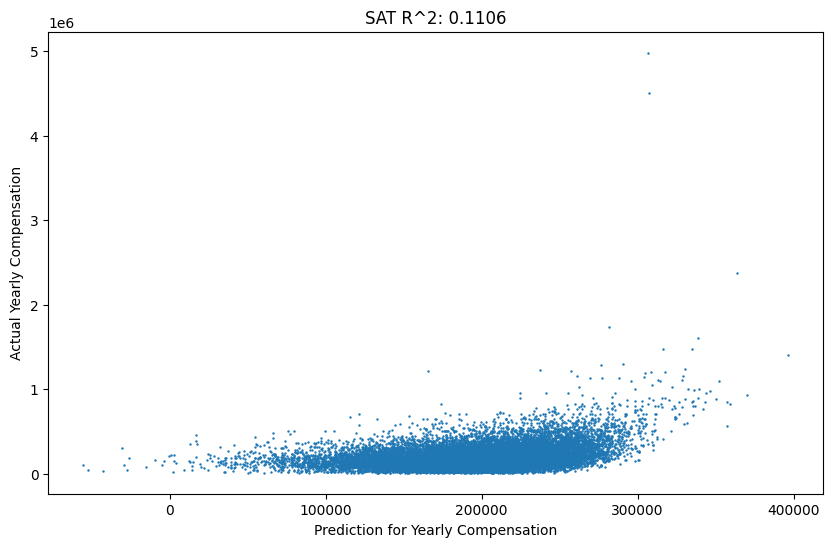

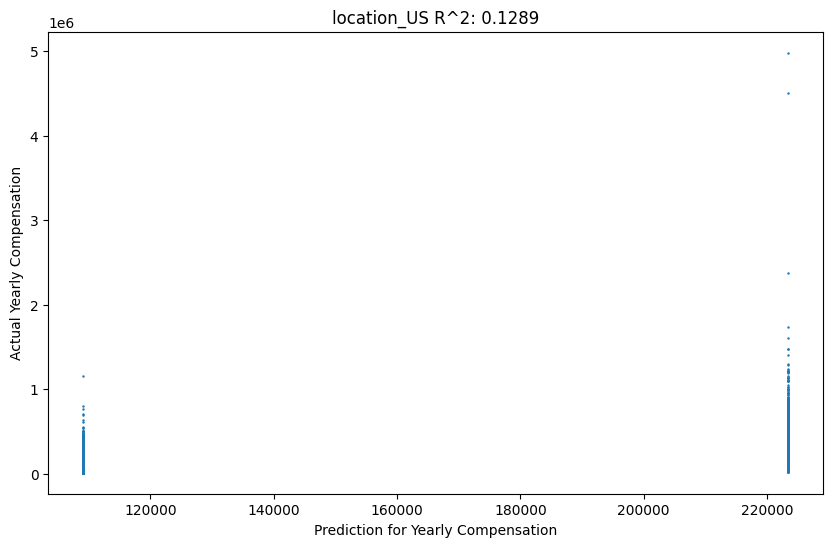

In [ ]:
# Evaluating individual predictors
entires, columns = X.shape

best_r2 = 0
best_predictor = None

for i in range(columns):
  X_single = X[:, i].reshape(-1, 1)
  model_single = LinearRegression()
  model_single.fit(X_single, y)
  r2_single = model_single.score(X_single, y)
  yHat = model_single.predict(X_single)

  print(f"{X_df.columns[i]} R^2: {r2_single:.4f}")

  if(r2_single > 0.10):
    plt.figure(figsize=(10, 6))
    plt.plot(yHat,y,'o',markersize=.75)
    plt.title(f'{X_df.columns[i]} R^2: {r2_single:.4f}')
    plt.xlabel('Prediction for Yearly Compensation')
    plt.ylabel('Actual Yearly Compensation')
    fig_name = f"{X_df.columns[i]}_linreg.png"
    plt.savefig(fig_name, dpi=300, bbox_inches='tight')



## Ridge Regression

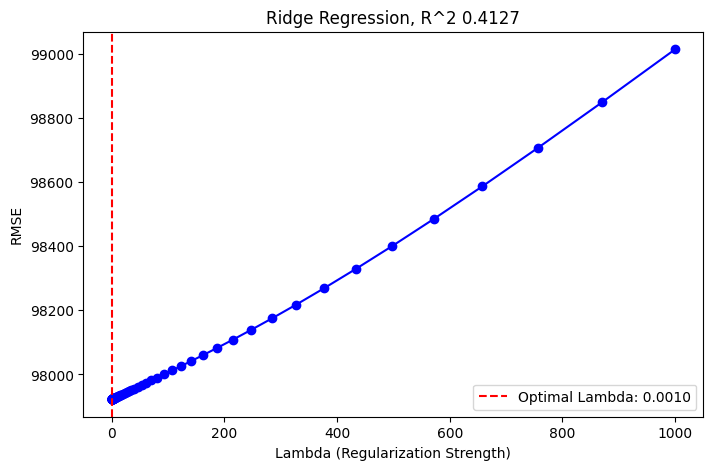

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

lambdas = np.logspace(-3, 3, 100) # lambdas
errors = np.empty([len(lambdas), 2]) * np.NaN  # Store lambda and corresponding error

for i, alpha in enumerate(lambdas): # for each lambda
    ridgeModel = Ridge(alpha=alpha)
    ridgeModel.fit(xTrain, yTrain)
    error = np.sqrt(mean_squared_error(yTest, ridgeModel.predict(xTest))) # computer error
    errors[i, 0] = alpha
    errors[i, 1] = error

optimal_lambda = lambdas[np.argmin(errors[:, 1])] # best lambda = lowest error
ridge_r2 = Ridge(alpha=optimal_lambda).fit(xTrain, yTrain).score(xTest, yTest)

# Lambda vs. RMSE
plt.figure(figsize=(8, 5))
plt.plot(errors[:, 0], errors[:, 1], marker='o', color='blue')
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("RMSE")
plt.title(f"Ridge Regression, R^2 {ridge_r2:.4f}")
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal Lambda: {optimal_lambda:.4f}')
plt.legend()
plt.savefig("ridge_regression_plot.png", dpi=300, bbox_inches='tight')
plt.show()

OLS R-squared: 0.4127, OLS RMSE: 97922.8674
Ridge R-squared: 0.4127, Ridge RMSE: 97922.8681


<Figure size 1000x600 with 0 Axes>

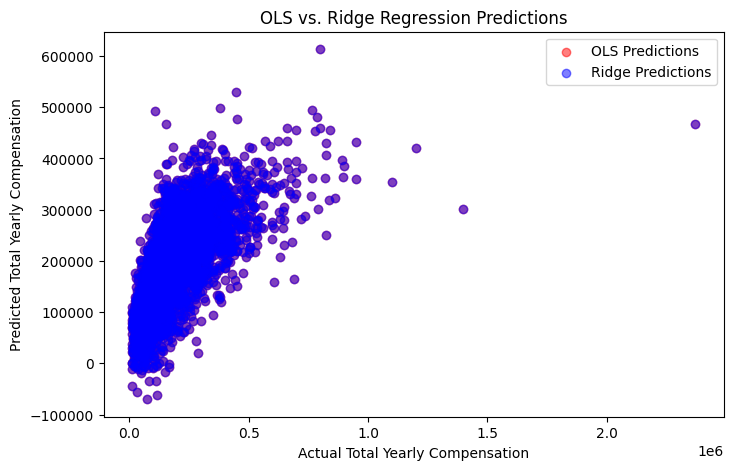

In [ ]:
# OLS Regression Model
ols_model = LinearRegression()
ols_model.fit(xTrain, yTrain)
ols_preds = ols_model.predict(xTest)
ols_r2 = ols_model.score(xTest, yTest)
ols_rmse = np.sqrt(mean_squared_error(yTest, ols_model.predict(xTest)))


# Ridge with best lambda
ridge_model = Ridge(alpha=optimal_lambda)
ridge_model.fit(xTrain, yTrain)
ridge_r2 = ridge_model.score(xTest, yTest)
ridge_preds = ridge_model.predict(xTest)
ridge_rmse = np.sqrt(mean_squared_error(yTest, ridge_preds))

# Print results
print(f"OLS R-squared: {ols_r2:.4f}, OLS RMSE: {ols_rmse:.4f}")
print(f"Ridge R-squared: {ridge_r2:.4f}, Ridge RMSE: {ridge_rmse:.4f}")


# Plotting predictions - purple = overlap
plt.figure(figsize=(10, 6))
plt.figure(figsize=(8, 5))
plt.scatter(yTest, ols_preds, color='red', alpha=0.5, label="OLS Predictions")
plt.scatter(yTest, ridge_preds, color='blue', alpha=0.5, label="Ridge Predictions")
plt.xlabel("Actual Total Yearly Compensation")
plt.ylabel("Predicted Total Yearly Compensation")
plt.title("OLS vs. Ridge Regression Predictions")
plt.legend()
plt.savefig("ols_vs_ridge_plot.png", dpi=300, bbox_inches='tight')
plt.show()

## Lasso Regression

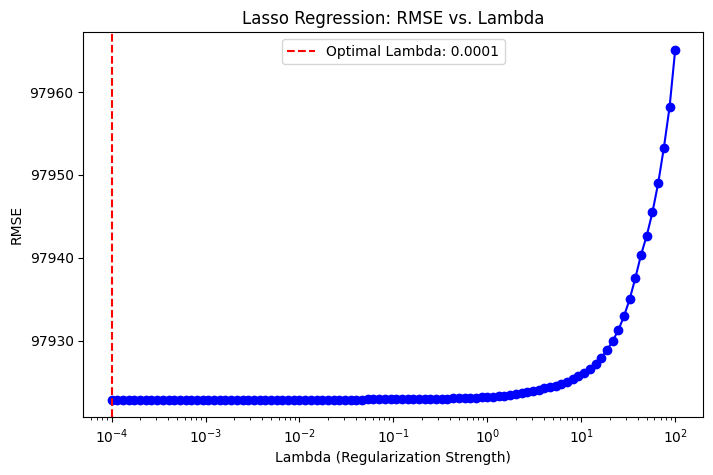

In [ ]:

xTrain, xTest, yTrain, yTest = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)
lambdas = np.logspace(-4, 2, 100)

lasso_errors = []
for alpha in lambdas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    lasso_model.fit(xTrain, yTrain.ravel())
    error = np.sqrt(mean_squared_error(yTest, lasso_model.predict(xTest)))
    lasso_errors.append((alpha, error))

lasso_errors = np.array(lasso_errors) # plotting
optimal_lambda_lasso, lasso_rmse = lasso_errors[np.argmin(lasso_errors[:, 1])]

# Lambda vs. RMSE for Lasso
plt.figure(figsize=(8, 5))
plt.plot(lasso_errors[:, 0], lasso_errors[:, 1], marker='o', color='blue')
plt.xscale("log")  # Log scale for better visualization
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("RMSE")
plt.title("Lasso Regression: RMSE vs. Lambda")
plt.axvline(optimal_lambda_lasso, color="red", linestyle="--", label=f"Optimal Lambda: {optimal_lambda_lasso:.4f}")
plt.legend()
plt.savefig("lasso_lambda_vs_rmse.png", dpi=300, bbox_inches='tight')
plt.show()


Number of predictors shrunk to zero by Lasso: 0
Ridge R-squared: 0.4127, Ridge RMSE: 97922.8681, Optimal Lambda: 0.0010
Lasso R-squared: 0.4127, Lasso RMSE: 97922.8674, Optimal Lambda: 0.0001


<Figure size 1000x600 with 0 Axes>

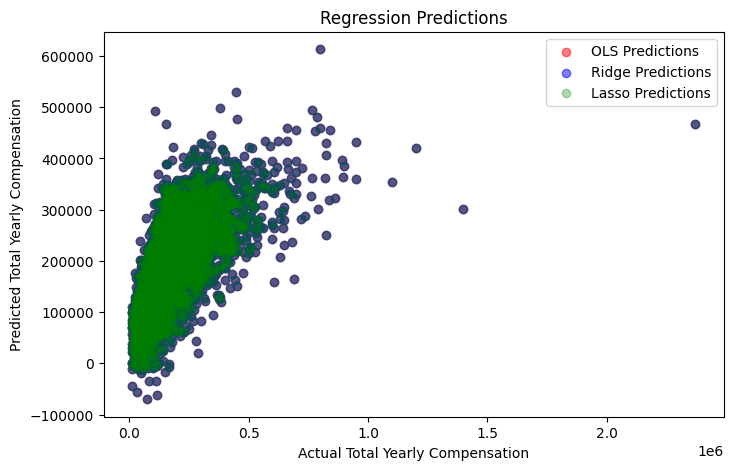

In [ ]:
# Fit Lasso with optimal lambda
lasso_model = Lasso(alpha=optimal_lambda_lasso, max_iter=10000)
lasso_model.fit(xTrain, yTrain.ravel())
lasso_r2 = lasso_model.score(xTest, yTest)
lasso_preds = lasso_model.predict(xTest)

# Count number of coefficients shrunk to exactly zero in Lasso
num_zero_coeffs = np.sum(lasso_model.coef_ == 0)
print(f"Number of predictors shrunk to zero by Lasso: {num_zero_coeffs}")

print(f"Ridge R-squared: {ridge_r2:.4f}, Ridge RMSE: {ridge_rmse:.4f}, Optimal Lambda: {optimal_lambda:.4f}")
print(f"Lasso R-squared: {lasso_r2:.4f}, Lasso RMSE: {lasso_rmse:.4f}, Optimal Lambda: {optimal_lambda_lasso:.4f}")

# Plotting predictions - purple = overlap
plt.figure(figsize=(10, 6))
plt.figure(figsize=(8, 5))
plt.scatter(yTest, ols_preds, color='red', alpha=0.5, label="OLS Predictions")
plt.scatter(yTest, ridge_preds, color='blue', alpha=0.5, label="Ridge Predictions")
plt.scatter(yTest, lasso_preds, color='green', alpha=0.3, label="Lasso Predictions")
plt.xlabel("Actual Total Yearly Compensation")
plt.ylabel("Predicted Total Yearly Compensation")
plt.title("Regression Predictions")
plt.legend()
plt.savefig("comp_preds.png", dpi=300, bbox_inches='tight')
plt.show()



## Wage Gap

In [ ]:
X_simple_scaled = std_df[['totalyearlycompensation']]  # Simple model (only total compensation)
X_full_scaled = std_df.drop(columns=['Gender_Male'])  # Full model (all predictors except gender)
y = std_df['Gender_Male']  # Outcome variable


X_train_s, X_val_s, y_train, y_val = train_test_split(X_simple_scaled, y, test_size=0.2, random_state=42) #split
X_train_f, X_val_f, _, _ = train_test_split(X_full_scaled, y, test_size=0.2, random_state=42)

model_simple = LogisticRegression(solver='liblinear') # simplified model
model_full = LogisticRegression(solver='liblinear') # full model
model_simple.fit(X_train_s, y_train)
model_full.fit(X_train_f, y_train)

pred_simple = model_simple.predict(X_val_s)
pred_full = model_full.predict(X_val_f)

In [ ]:
# Evaluate performance for Simple Model
accuracy_simple = metrics.accuracy_score(y_val, pred_simple)
conf_matrix_simple = metrics.confusion_matrix(y_val, pred_simple)
precision_simple = metrics.precision_score(y_val, pred_simple)
recall_simple = metrics.recall_score(y_val, pred_simple)

print("\nSIMPLE MODEL PERFORMANCE:")
print(f"Accuracy = {accuracy_simple * 100:.1f}%")
print("Confusion Matrix:\n", conf_matrix_simple)
print(f"Precision = {precision_simple * 100:.1f}%")
print(f"Recall    = {recall_simple * 100:.1f}%")

# Evaluate performance for Full Model
accuracy_full = metrics.accuracy_score(y_val, pred_full)
conf_matrix_full = metrics.confusion_matrix(y_val, pred_full)
precision_full = metrics.precision_score(y_val, pred_full)
recall_full = metrics.recall_score(y_val, pred_full)

print("\nFULL MODEL PERFORMANCE:")
print(f"Accuracy = {accuracy_full * 100:.1f}%")
print("Confusion Matrix:\n", conf_matrix_full)
print(f"Precision = {precision_full * 100:.1f}%")
print(f"Recall    = {recall_full * 100:.1f}%")


SIMPLE MODEL PERFORMANCE:
Accuracy = 82.3%
Confusion Matrix:
 [[   0  760]
 [   0 3537]]
Precision = 82.3%
Recall    = 100.0%

FULL MODEL PERFORMANCE:
Accuracy = 82.3%
Confusion Matrix:
 [[   0  760]
 [   0 3537]]
Precision = 82.3%
Recall    = 100.0%


<Figure size 1000x500 with 0 Axes>

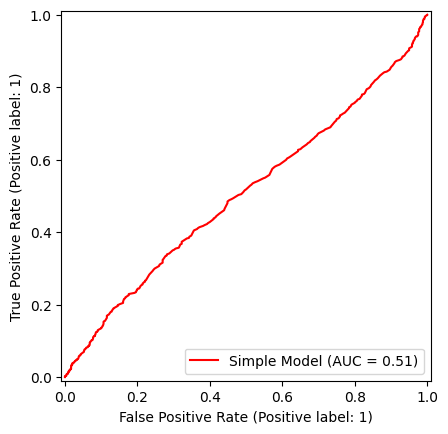

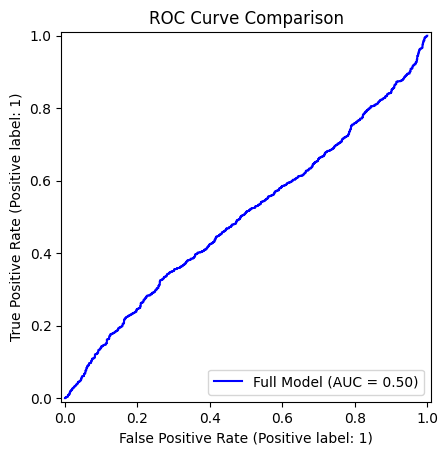

<Figure size 1000x500 with 0 Axes>

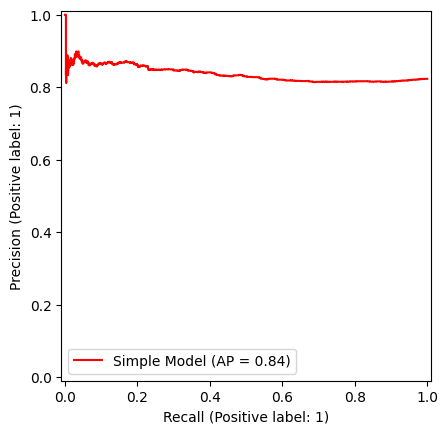

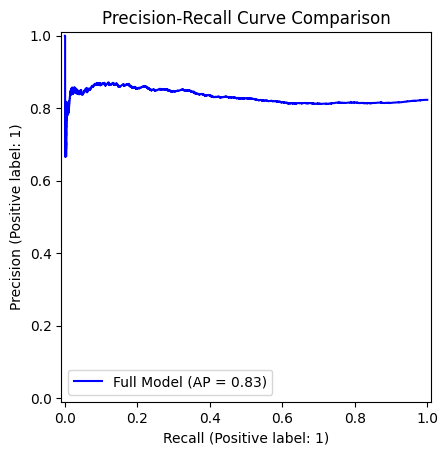

In [ ]:
# Get predicted probabilities
pred_probs_simple = model_simple.predict_proba(X_val_s)[:, 1]  # Probability of class 1 (Male)
pred_probs_full = model_full.predict_proba(X_val_f)[:, 1]

# ROC Curve Comparison
plt.figure(figsize=(10, 5))
metrics.RocCurveDisplay.from_predictions(y_val, pred_probs_simple, name="Simple Model", color="red")
metrics.RocCurveDisplay.from_predictions(y_val, pred_probs_full, name="Full Model", color="blue")
plt.title("ROC Curve Comparison")
plt.savefig("roc_curve_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve Comparison
plt.figure(figsize=(10, 5))
metrics.PrecisionRecallDisplay.from_predictions(y_val, pred_probs_simple, name="Simple Model", color="red")
metrics.PrecisionRecallDisplay.from_predictions(y_val, pred_probs_full, name="Full Model", color="blue")
plt.title("Precision-Recall Curve Comparison")
plt.savefig("prc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

## High and Low Pay

In [ ]:
pay_df = std_df.copy() # use standardized variables

In [ ]:
median_salary = pay_df['totalyearlycompensation'].median() # splitting high and low according to median
pay_df['high_pay'] = (pay_df['totalyearlycompensation'] > median_salary).astype(int)  # 1 = High Pay, 0 = Low Pay

X = pay_df[['yearsofexperience', 'Age', 'Height', 'SAT', 'GPA']] # predictors
y = pay_df['high_pay']


# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Get predictions
preds = model.predict(X_val)
pred_probs = model.predict_proba(X_val)[:, 1]  # Probabilities of high pay



LOGISTIC REGRESSION MODEL PERFORMANCE:
Accuracy = 67.6%
Confusion Matrix:
 [[1573  582]
 [ 811 1331]]
Precision = 69.6%
Recall    = 62.1%


<Figure size 1000x500 with 0 Axes>

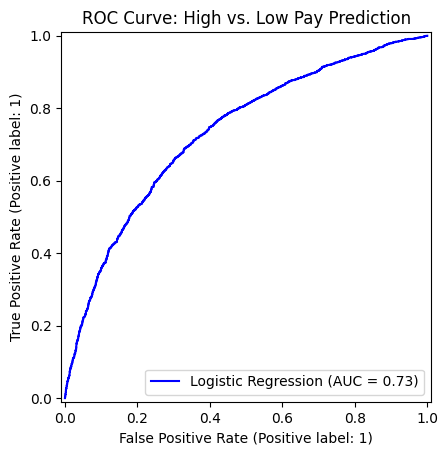

<Figure size 1000x500 with 0 Axes>

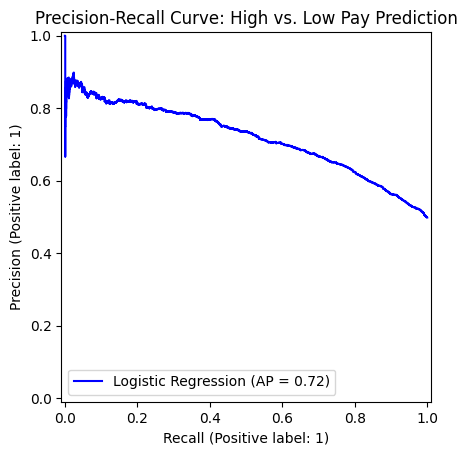

In [ ]:
# Evaluate Model Performance
accuracy = metrics.accuracy_score(y_val, preds)
conf_matrix = metrics.confusion_matrix(y_val, preds)
precision = metrics.precision_score(y_val, preds)
recall = metrics.recall_score(y_val, preds)

# Print Results
print("\nLOGISTIC REGRESSION MODEL PERFORMANCE:")
print(f"Accuracy = {accuracy * 100:.1f}%")
print("Confusion Matrix:\n", conf_matrix)
print(f"Precision = {precision * 100:.1f}%")
print(f"Recall    = {recall * 100:.1f}%")

# ROC Curve
plt.figure(figsize=(10, 5))
metrics.RocCurveDisplay.from_predictions(y_val, pred_probs, name="Logistic Regression", color="blue")
plt.title("ROC Curve: High vs. Low Pay Prediction")
plt.savefig("roc_curve_high_low_pay.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 5))
metrics.PrecisionRecallDisplay.from_predictions(y_val, pred_probs, name="Logistic Regression", color="blue")
plt.title("Precision-Recall Curve: High vs. Low Pay Prediction")
plt.savefig("prc_curve_high_low_pay.png", dpi=300, bbox_inches='tight')
plt.show()